In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
import time
import copy
# from lmphoton.simulation import current_simulation as sim
import pandas as pd

import sys
sys.path.append("../")

# SPPD optical elements
from src.sppd_clm_optics import SPPDCLMOPTICS, SPPDCLMOPTICS_LAMBDA_AB

# PMIC drivers
from src.pikeriver_pmic import PMIC

# Calibration and control
from src.sppd_clm import CONTROLLER
from src.laser_control.pid import pid as PID

plt.style.use("plot_style.mplstyle")
warnings.filterwarnings("ignore")

In [2]:
target_grid_array = np.array([
  1301.47, 1302.60, 1303.73, 1304.87,
  1306.01, 1307.14, 1308.28, 1309.43,
  1310.57, 1311.72, 1312.87, 1314.02,
  1315.17, 1316.33, 1317.48, 1318.64
  ])*1e-9 

wavelength_fabrication = np.array([1.30150695e-06, 1.30266500e-06, 1.30381006e-06, 1.30500515e-06,
       1.30605274e-06, 1.30707336e-06, 1.30832819e-06, 1.30946877e-06,
       1.31060618e-06, 1.31173168e-06, 1.31281666e-06, 1.31414471e-06,
       1.31525203e-06, 1.31619448e-06, 1.31740494e-06, 1.31861709e-06]) - 0.5e-9

wavelength_fabrication_easy = target_grid_array - 0.5e-9

In [3]:
_sppd_clm_optics = SPPDCLMOPTICS_LAMBDA_AB(
  current = 0.133,
  target_grid_array = target_grid_array,
  wavelength_fabrication= wavelength_fabrication,
  nominal_junction_temperature=273+44.5,
  bw_lambda = 0.2e-9,
  sppd_eb_atten_dB = 1.72,
  name = "SPPDCLMOPTICS",
  no_mux = 1
  )

print("Wavelength fabrication")
print(_sppd_clm_optics._sppd_clm_pic._lambda_array*1e9)
print("\nCase temperature")
print(_sppd_clm_optics._temperature-273)
current_array = np.ones(16) * 0.133
_sppd_clm_optics.update(tc = 273+42.5, i_array=current_array)

_laser_array_sppd_clm = _sppd_clm_optics._lambda_array

print("\nWavelength after update")
print(_sppd_clm_optics._lambda_array*1e9)
print("\nTarget wavelength ideal")
print(_sppd_clm_optics._target_grid_array*1e9)
print("\n Current array")
print(_sppd_clm_optics._sppd_clm_pic_mpd_current_array)


Wavelength fabrication
[1301.00695 1302.165   1303.31006 1304.50515 1305.55274 1306.57336
 1307.82819 1308.96877 1310.10618 1311.23168 1312.31666 1313.64471
 1314.75203 1315.69448 1316.90494 1318.11709]

Case temperature
44.5

Wavelength after update
[1301.46087374 1302.64425855 1303.80413196 1305.01002284 1306.06577934
 1307.09235442 1308.35109879 1309.49361994 1310.63102993 1311.7545888
 1312.83565441 1314.1577484  1315.2569014  1316.18855275 1317.38417556
 1318.5715258 ]

Target wavelength ideal
[1301.47 1302.6  1303.73 1304.87 1306.01 1307.14 1308.28 1309.43 1310.57
 1311.72 1312.87 1314.02 1315.17 1316.33 1317.48 1318.64]

 Current array
[0.00031557 0.00031557 0.00031557 0.00031557 0.00031557 0.00031557
 0.00031557 0.00031557 0.00031557 0.00031557 0.00031557 0.00031557
 0.00031557 0.00031557 0.00031557 0.00031557]


In [4]:
_pk_pmic = PMIC()

dt = 10e-3
_pid_tec = pid_tec = PID(kp=0.5, ki=10*dt, kd=10*dt, dt=dt, umax=3, umin=-3)
_pid_idrive = [PID(kp=1/1000, ki=1/1000, kd=1/1000, dt=dt, umax = 1024, umin=-1024) for __ in range(len(wavelength_fabrication))]

In [5]:
controller = CONTROLLER(
  sppd_clm_optics = _sppd_clm_optics,
  pmic = _pk_pmic,
  drive_current_array = current_array,
  pid_tec = _pid_tec,
  pid_idrive = _pid_idrive,
  dt = dt,
)


controller._tend = 20
controller._tdither = 5
controller._tagg_1 = 15.0
controller._tagg_2 = 17.5
controller._agg_1_amp = 1
controller._agg_2_amp = 1

In [6]:
start = time.time()
controller.calibrate(tc=273+35,
            temperature_array = np.linspace(30, 50, 201)+273, 
            drive_current_array= np.linspace(0.1, 0.2, 101),
            power_wavelength_calibration=True,
            tec_temperature_tuning=True,
            drive_current_tuning=False,
            )
print(f"Calibration time: {time.time()-start:0.2f} s")

Calibration time: 3.29 s


In [7]:
nom_temp_array = controller._nominal_temperature_array
tec_set_point_temperature = controller._tec_set_point_temperature
mux_current_array = controller._pmic_adc_enablence_mux_mpd_current_array
peak_current_array = controller._pmic_adc_enablence_mux_mpd_peak_current_array
output_power_array = controller._enablence_output_power_array
output_lambda_array = controller._lambda_array
current_array = controller._drive_current_array
cal_temperature_array = controller._temperature_array
drive_current_array = controller._pmic._dac_laser_drive_current_array
laser_junction_temperature_array = controller._laser_junction_temperature_array

Laser TEC temp 0: 42.50 C, Laser Junction temp 0: 56.50 C, Enablence MPD current 0: 100.00, Pout 0: 17.67 mW, Lambda 0: 1301.46 nm, Drive current 0: 132.71 mA
Laser TEC temp 1: 42.20 C, Laser Junction temp 1: 56.74 C, Enablence MPD current 1: 104.00, Pout 1: 19.37 mW, Lambda 1: 1302.61 nm, Drive current 1: 133.09 mA
Laser TEC temp 2: 41.60 C, Laser Junction temp 2: 56.82 C, Enablence MPD current 2: 68.00, Pout 2: 18.80 mW, Lambda 2: 1303.70 nm, Drive current 2: 129.60 mA
Laser TEC temp 3: 41.20 C, Laser Junction temp 3: 56.92 C, Enablence MPD current 3: 136.00, Pout 3: 18.71 mW, Lambda 3: 1304.87 nm, Drive current 3: 130.03 mA
Laser TEC temp 4: 42.10 C, Laser Junction temp 4: 57.05 C, Enablence MPD current 4: 138.00, Pout 4: 19.15 mW, Lambda 4: 1306.02 nm, Drive current 4: 131.87 mA
Laser TEC temp 5: 43.00 C, Laser Junction temp 5: 57.13 C, Enablence MPD current 5: 80.00, Pout 5: 19.15 mW, Lambda 5: 1307.14 nm, Drive current 5: 131.83 mA
Laser TEC temp 6: 41.70 C, Laser Junction temp 6

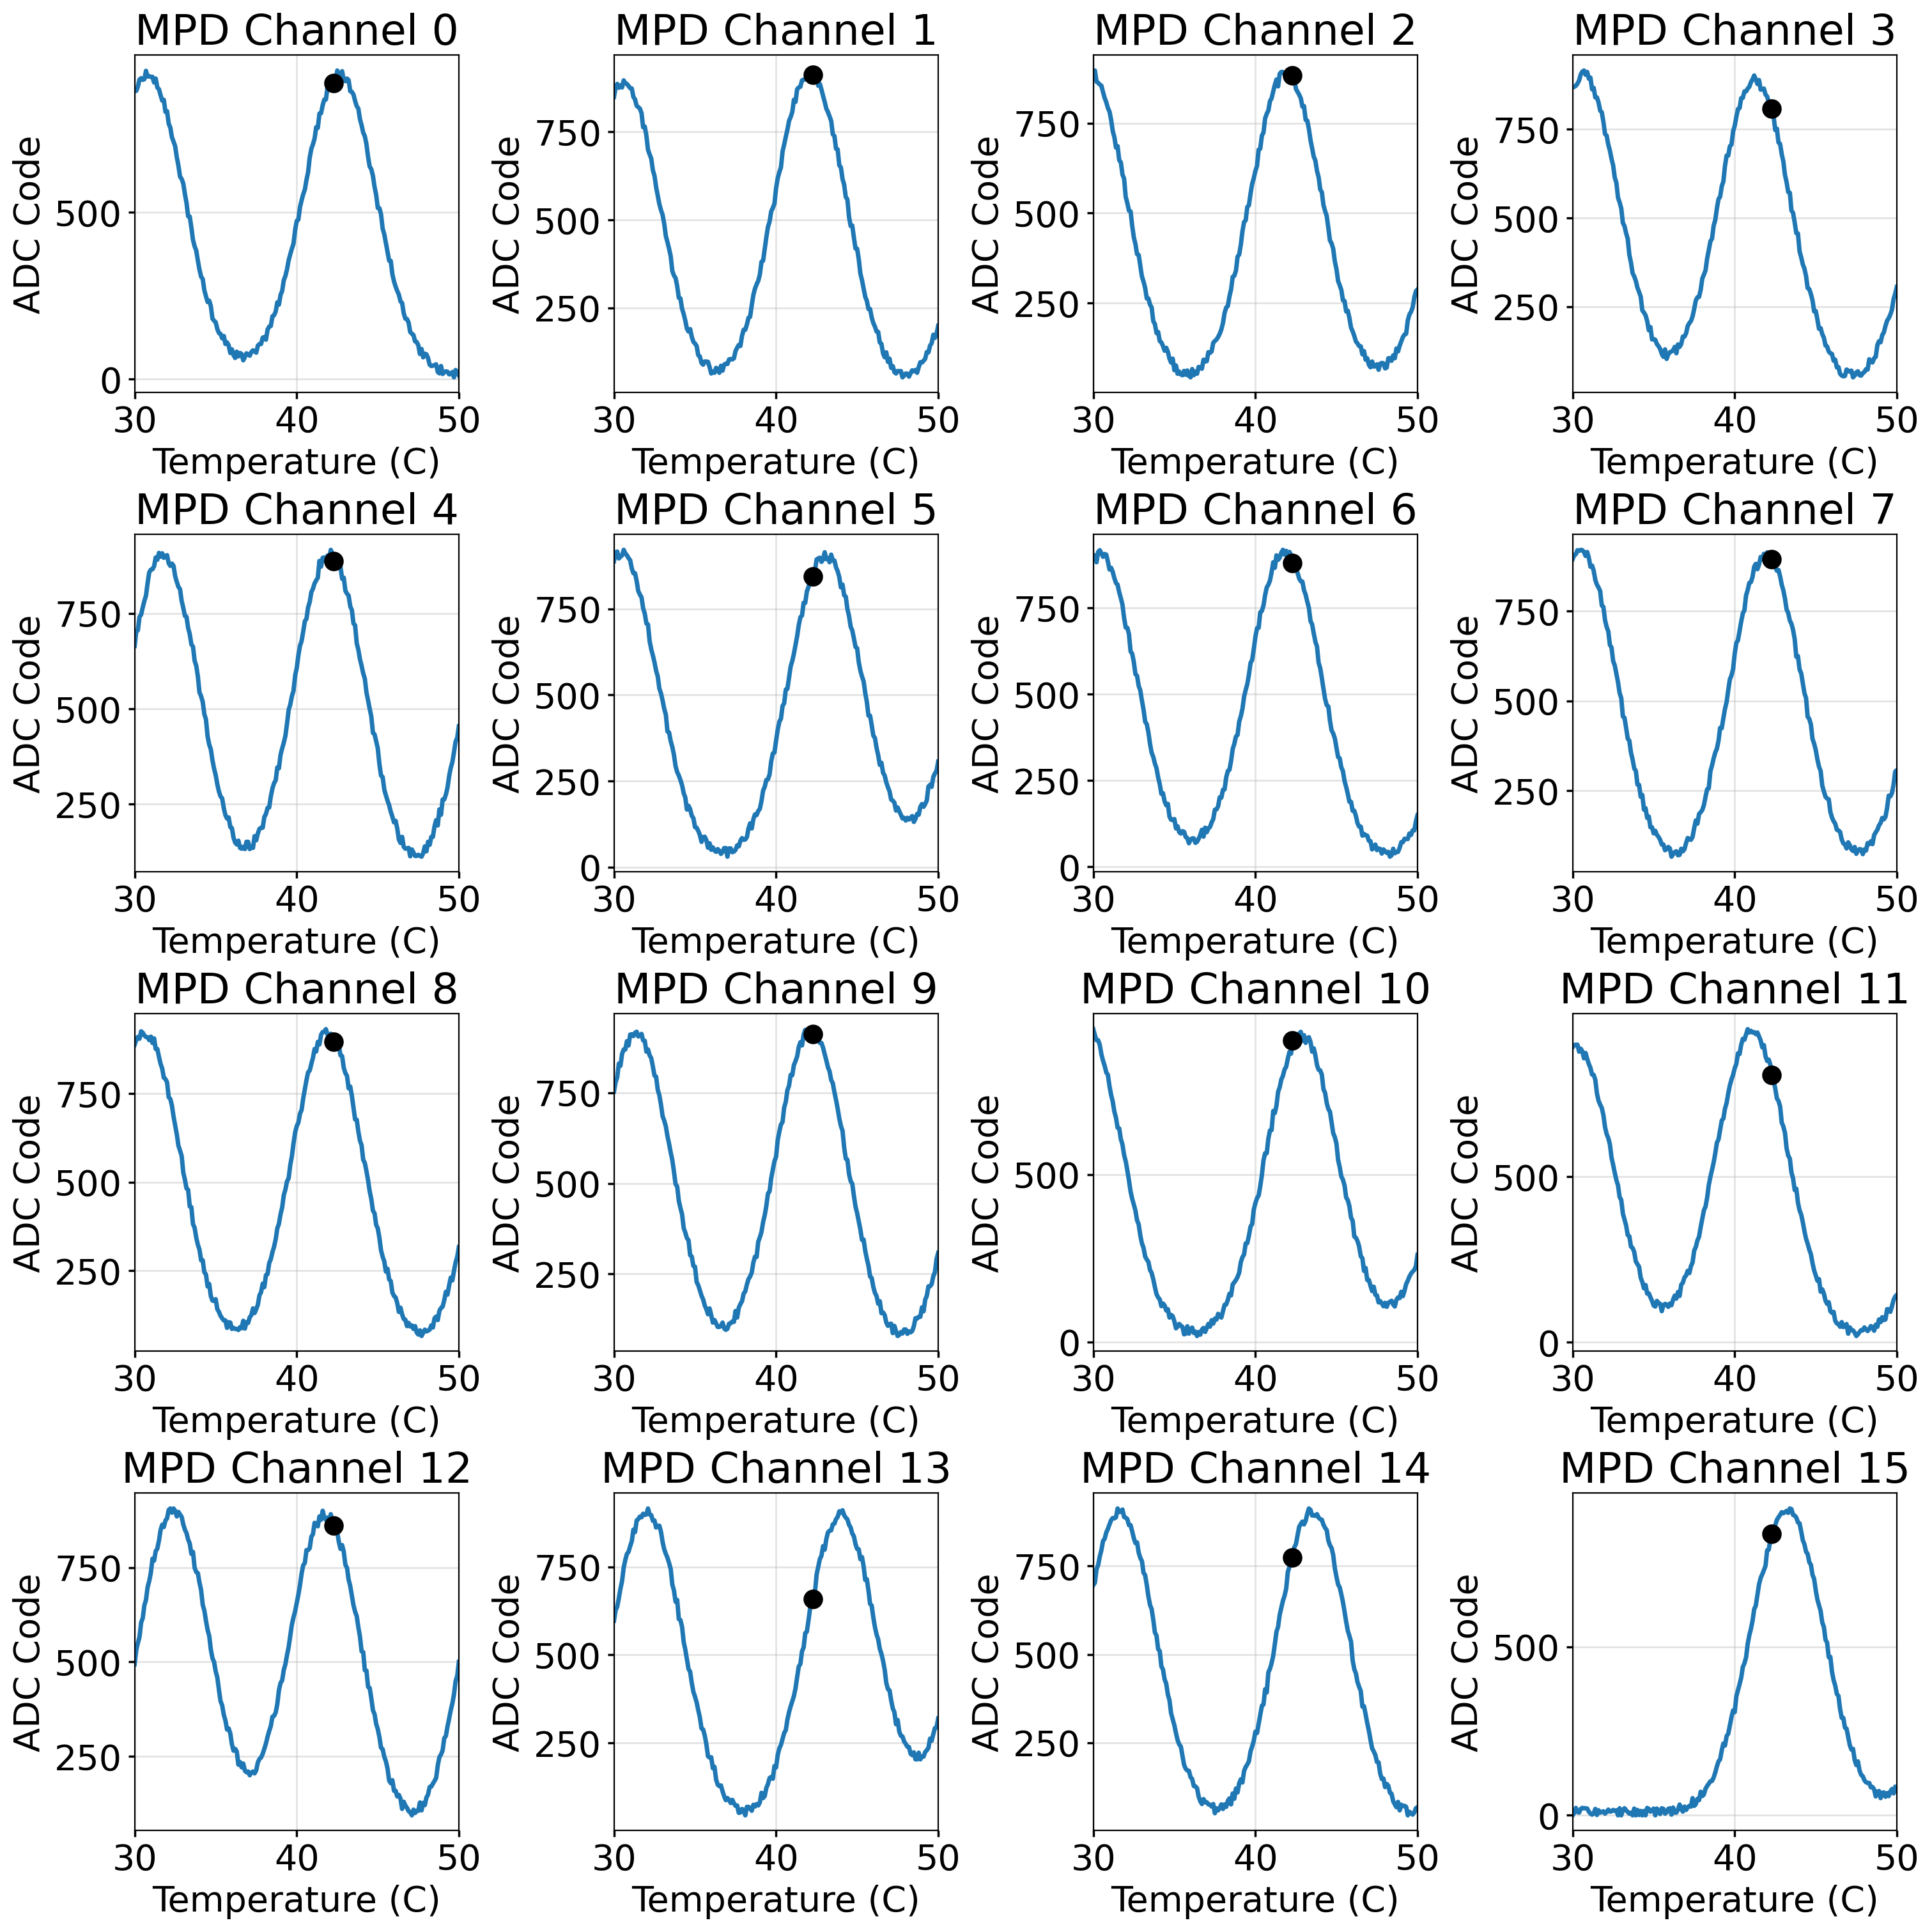

In [8]:
for idd_laser in range(16):
  print(f"Laser TEC temp {idd_laser}: {nom_temp_array[idd_laser]-273:0.2f} C, Laser Junction temp {idd_laser}: {laser_junction_temperature_array[idd_laser]-273:0.2f} C, Enablence MPD current {idd_laser}: {peak_current_array[idd_laser]:0.2f}, Pout {idd_laser}: {output_power_array[idd_laser]*1e3:0.2f} mW, Lambda {idd_laser}: {output_lambda_array[idd_laser]*1e9:0.2f} nm, Drive current {idd_laser}: {drive_current_array[idd_laser]*1e3:0.2f} mA")
print(f"TEC set point temperature: {tec_set_point_temperature-273:0.2f} C")

# Plot calibration per MUX channel (columns) and temperature (rows)
n_mpd_channels = len(target_grid_array)
# Set font size small
plt.rc('font', size=6)
fig, ax = plt.subplots(int(np.sqrt(n_mpd_channels)), int(np.sqrt(n_mpd_channels)), figsize=(15, 15))
for idd_mpd_channel in range(n_mpd_channels):
  _ax = ax[int(idd_mpd_channel/np.sqrt(n_mpd_channels)), int(idd_mpd_channel%np.sqrt(n_mpd_channels))]
  _ax.plot(cal_temperature_array-273, mux_current_array[:, idd_mpd_channel])
  idd_tec_temp = np.argmin(np.abs(cal_temperature_array - tec_set_point_temperature))
  _ax.plot(tec_set_point_temperature-273, mux_current_array[idd_tec_temp, idd_mpd_channel], 'o', color='k')
  _ax.set_xlim([30,50])
  _ax.set_xlabel("Temperature (C)")
  _ax.set_ylabel("ADC Code")
  _ax.set_title(f"MPD Channel {idd_mpd_channel}")

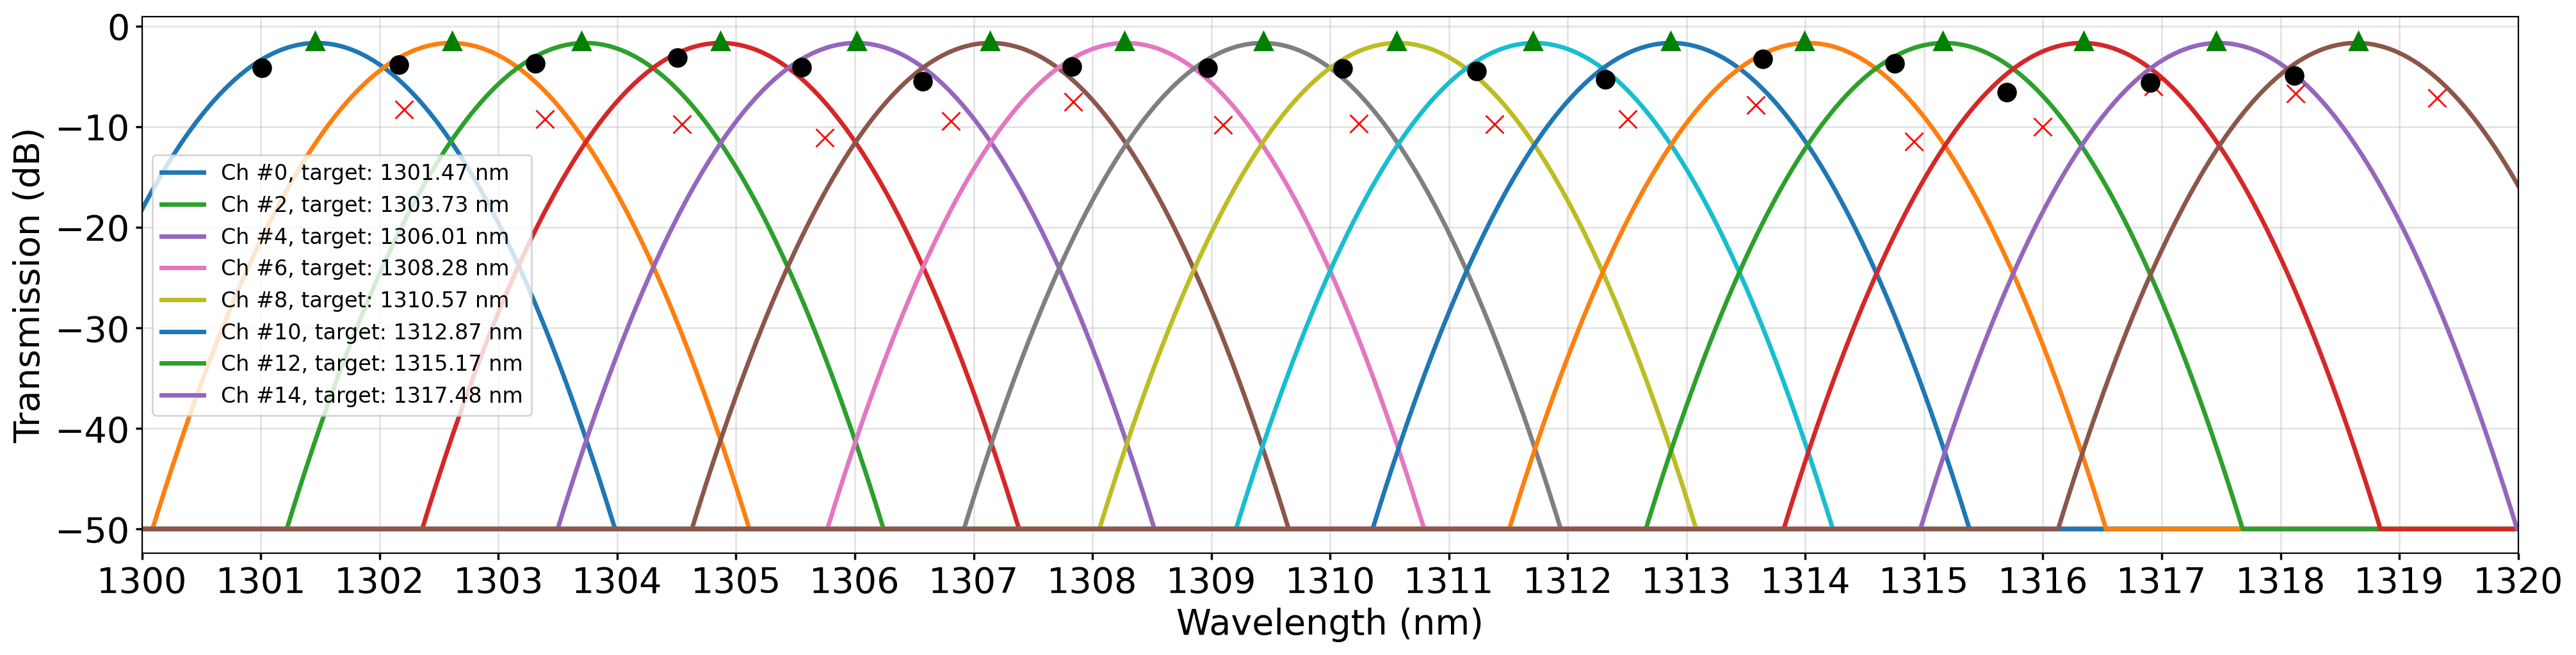

In [9]:
_enablence_mux = _sppd_clm_optics._ebmux

wavelength_fabrication_arg = [np.argmin(np.abs(_enablence_mux.lambda_sweep - wavelength_fabrication[idd_target])) for idd_target in range(len(target_grid_array))]
wavelength_output_arg = [np.argmin(np.abs(_enablence_mux.lambda_sweep - output_lambda_array[idd_target])) for idd_target in range(len(target_grid_array))]
wavelength_clm_standalone = _sppd_clm_optics._lambda_array
wavelength_clm_standalone_arg = [np.argmin(np.abs(_enablence_mux.lambda_sweep - wavelength_clm_standalone[idd_target])) for idd_target in range(len(target_grid_array))]

plt.figure(figsize=(20,5))
for idd_target in range(len(target_grid_array)):
  if idd_target%2 == 0:
    plt.plot(_enablence_mux.lambda_sweep*1e9, 10*np.log10(_enablence_mux.ebmux_tf_array_list[idd_target,:]), label="Ch #{:0.0f}, target: {:.2f} nm".format(idd_target, target_grid_array[idd_target]*1e9)) 
  else:
    plt.plot(_enablence_mux.lambda_sweep*1e9, 10*np.log10(_enablence_mux.ebmux_tf_array_list[idd_target,:])) 

  plt.plot(wavelength_fabrication[idd_target]*1e9, 10*np.log10(_enablence_mux.enablence_mux_tf_array_list[idd_target,wavelength_fabrication_arg[idd_target]]), "o", color='k')
  plt.plot(output_lambda_array[idd_target]*1e9, 10*np.log10(_enablence_mux.enablence_mux_tf_array_list[idd_target,wavelength_output_arg[idd_target]]), "^", color='g')
  plt.plot(wavelength_clm_standalone[idd_target]*1e9, 10*np.log10(_enablence_mux.enablence_mux_tf_array_list[idd_target,wavelength_clm_standalone_arg[idd_target]]), "x", color='r')
plt.xlim([1300, 1320])
plt.xticks(np.arange(1300, 1321, 1))
plt.legend(fontsize=12)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Transmission (dB)")
plt.grid(True)

In [10]:
start = time.time()
controller._tec_set_point_temperature = controller._tec_set_point_temperature
controller.control(lin_sweep_range=0.2, output_power_clamp_bool = True, output_power_clamp = 0.038)

print(f"Control time: {time.time()-start:0.2f} s")

Control time: 13.65 s


In [11]:
t = controller._t
laser_drive_current_array = controller._drive_current_array_time_step
laser_output_power_array = controller._enablence_output_power_array_time_step
laser_wavelength_array = controller._enablence_output_lambda_array_time_step
laser_mpd_current_array = controller._pmic_adc_clm_pic_mpd_code_time_step
sppd_pout_array = controller._sppd_pout_array_time_step
laser_mux_mpd_current_array = controller._pmic_adc_enablence_mux_mpd_code_time_step
laser_junction_temperature_array = controller._sppd_laser_junction_temperature_array_time_step
q = controller._q
i_tec = controller._i_tec
v_tec = controller._v_tec
t_case = controller._t_case

wavelength_error = copy.deepcopy(laser_wavelength_array)
for idd_laser in range(16):
  wavelength_error[idd_laser,:] = laser_wavelength_array[idd_laser,:] - target_grid_array[idd_laser]

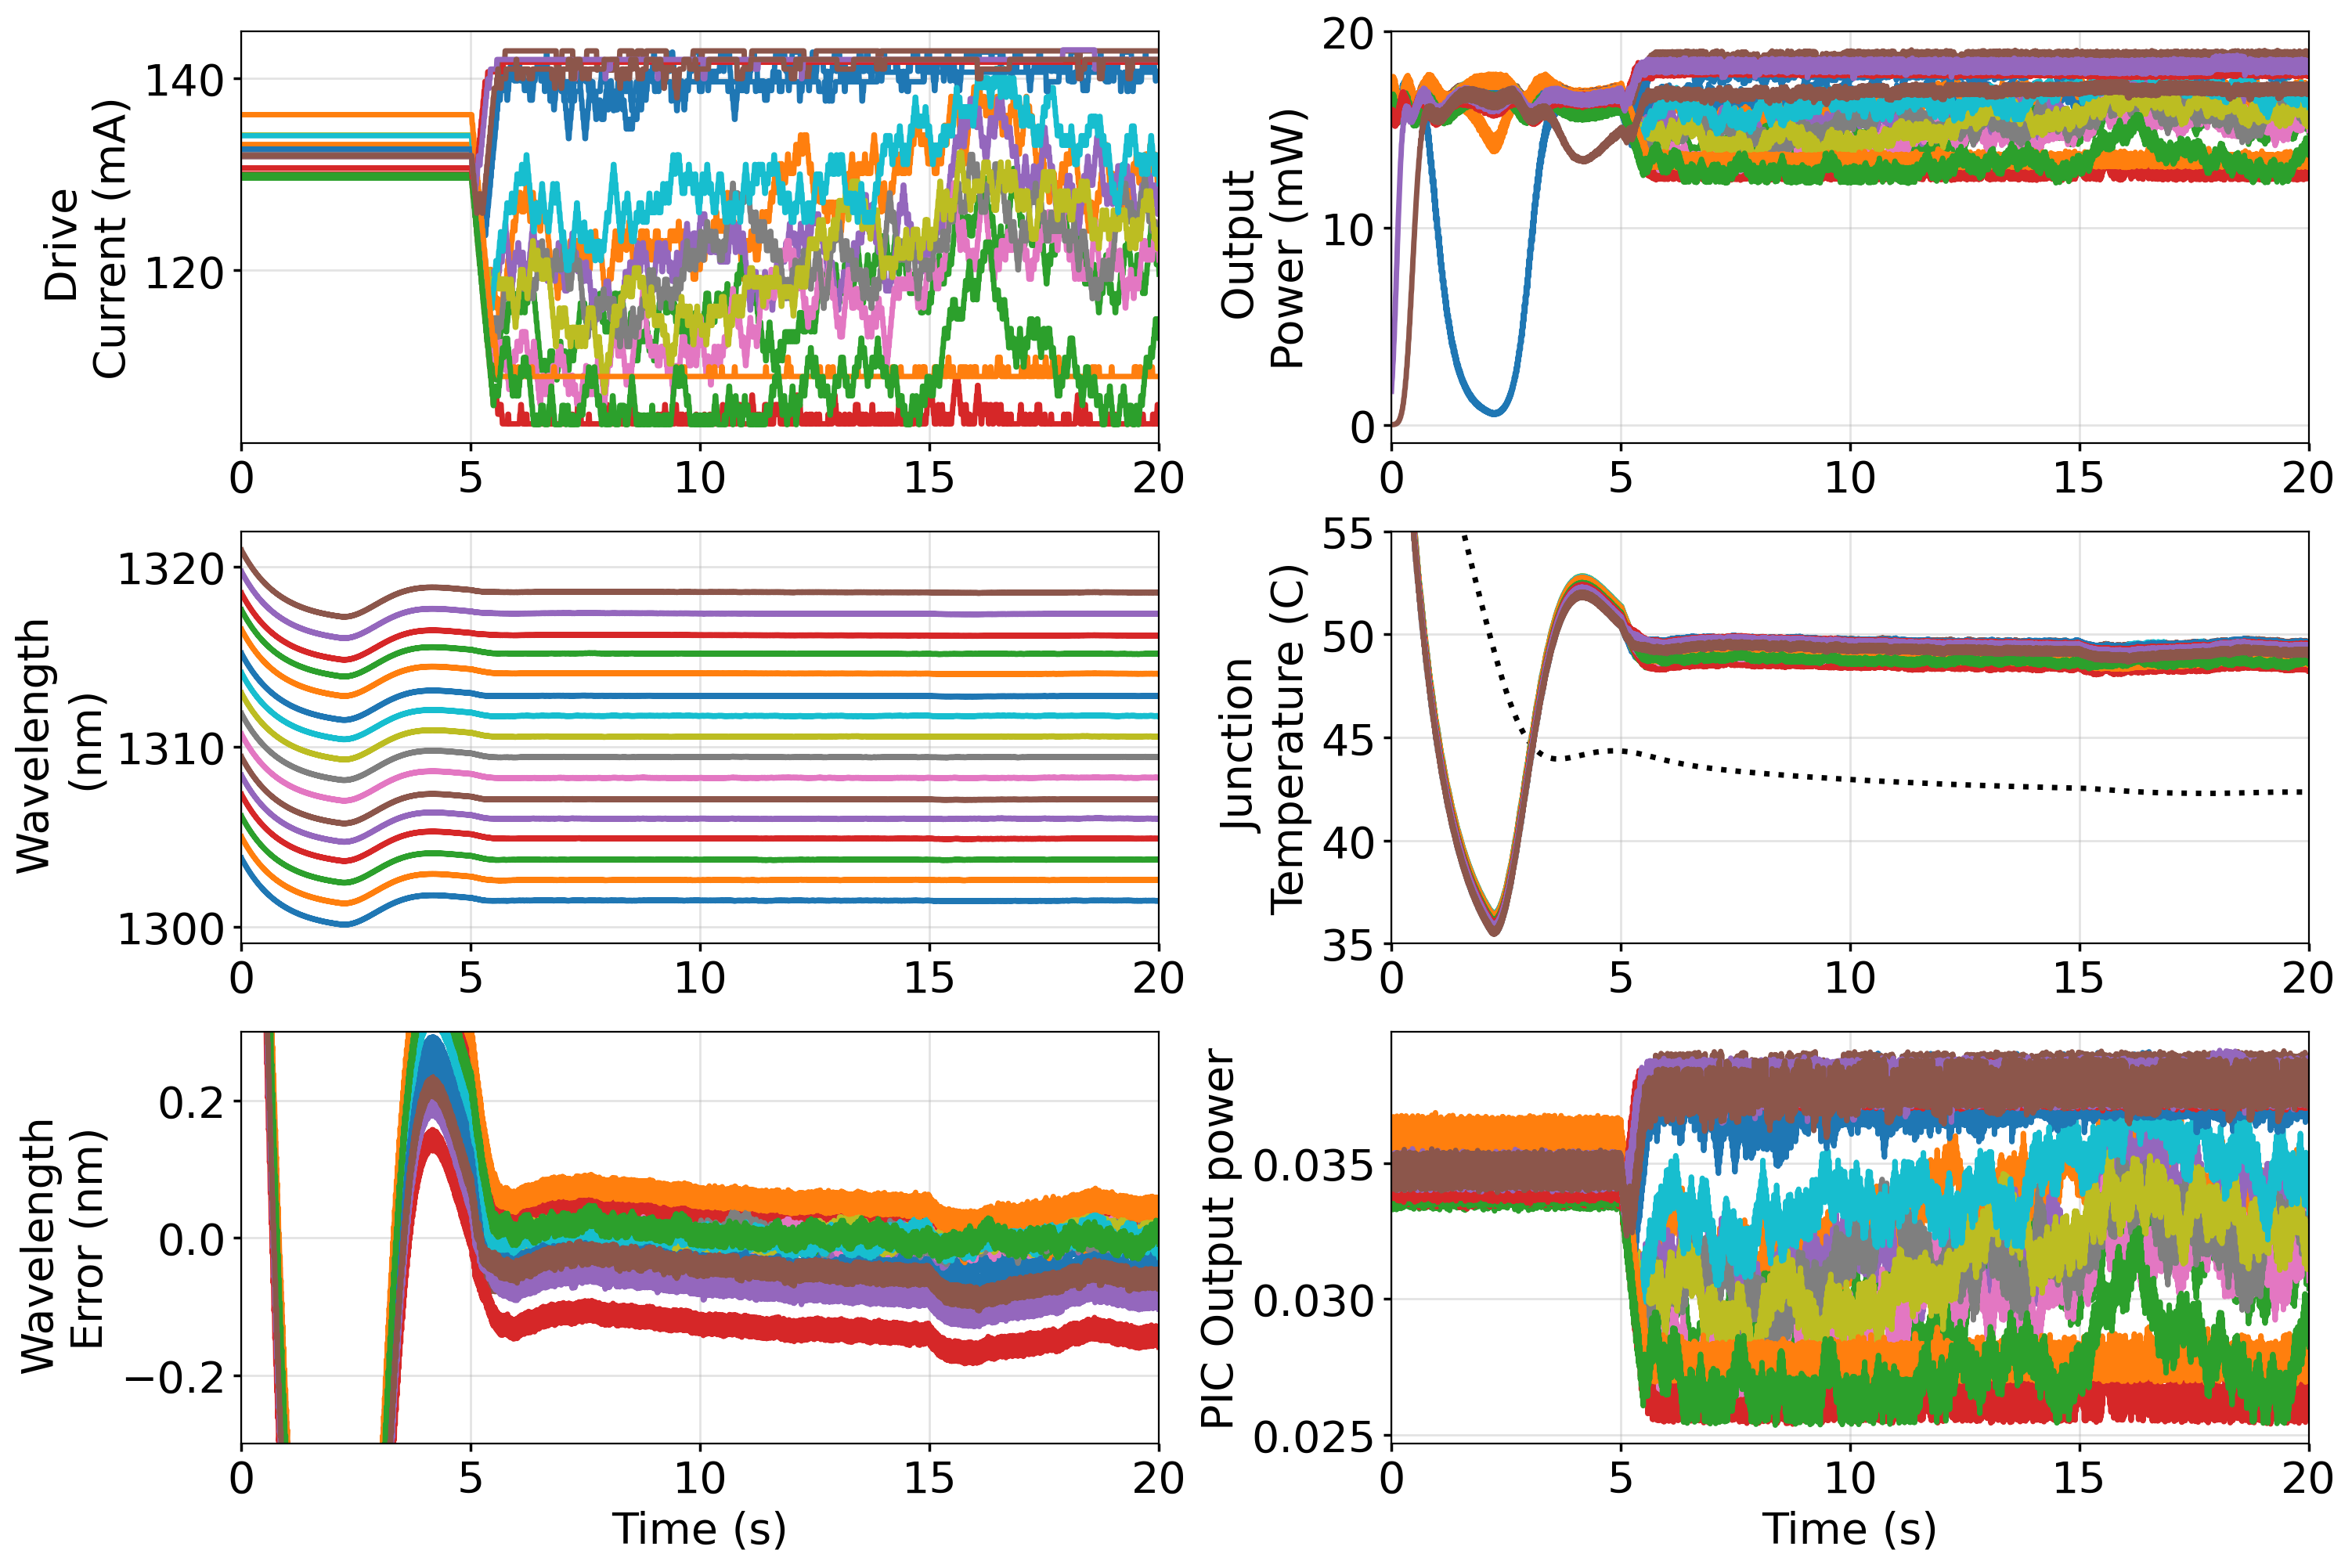

In [14]:
fig, ax = plt.subplots(3, 2, figsize=(15, 10))
xlim = [0,20]
ax[0, 0].plot(t, laser_drive_current_array.T*1e3)
ax[0, 0].set_ylabel("Drive \nCurrent (mA)")
ax[0, 1].plot(t, laser_output_power_array.T*1e3)
# ax[0, 1].set_ylim([5, 25])
ax[0, 1].set_ylabel("Output \nPower (mW)")
ax[1, 0].plot(t, laser_wavelength_array.T*1e9)
ax[1, 0].set_ylabel("Wavelength \n(nm)")
ax[1, 1].plot(t, t_case-273, linestyle = ':',color = 'k')
ax[1, 1].plot(t, laser_junction_temperature_array.T-273)
ax[1,1].set_ylim([35, 55])
ax[1, 1].set_ylabel("Junction \nTemperature (C)")
ax[2, 0].plot(t, wavelength_error.T*1e9)
ax[2, 0].set_xlabel("Time (s)")
ax[2, 0].set_ylabel("Wavelength \nError (nm)")
ax[2, 0].set_ylim(-1, 1)
ax[2,0].set_ylim([-0.3, 0.3])
ax[2, 1].plot(t, sppd_pout_array.T)
ax[2, 1].set_xlabel("Time (s)")
ax[2, 1].set_ylabel("PIC Output power")
for i in range(3):
  for j in range(2):
    ax[i,j].set_xlim(xlim)
plt.tight_layout()